# Data Embedding

## Column embedding using GloVe

In [1]:
import numpy as np
import torch
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# Download and load pre-trained GloVe embeddings
from gensim.models import KeyedVectors
glove_model = KeyedVectors.load_word2vec_format('glove.6B.100d.txt', no_header=True)

# Define a function to preprocess text data
def preprocess_text(text):
    # Lowercase, remove punctuation, tokenize
    text = text.lower().strip().replace(",", " ").replace(".", " ")
    tokens = tokenizer.tokenize(text, return_tensors="pt")
    return tokens

# Function to get word embeddings (Glove)
def get_embeddings(text):
    embeddings = []
    for word in text.split():
        # Check if word exists in vocabulary
        if word in glove_model.key_to_index:
        embeddings.append(glove_model[word])
        else:
        embeddings.append(np.zeros(100))  # Use zero vector for missing words
    # Average word embeddings to get sentence embedding
    return np.mean(embeddings, axis=0)


Some weights of the model checkpoint at ainize/bart-base-cnn were not used when initializing BartForSequenceClassification: ['final_logits_bias', 'lm_head.weight']
- This IS expected if you are initializing BartForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BartForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BartForSequenceClassification were not initialized from the model checkpoint at ainize/bart-base-cnn and are newly initialized: ['classification_head.out_proj.weight', 'classification_head.dense.weight', 'classification_head.out_proj.bias', 'classification_head.dense.bias']
You should probably TRAIN this model on a down-strea

In [3]:
# Evaluate Glove and ELMO embeddings
glove_embeddings = [get_embeddings(text) for text in train_texts]

In [7]:
import pandas as pd
import os

In [8]:
tables = []
for i in os.listdir("./"):
    if os.path.splitext(i)[1] == ".csv" and i not in ["dev.csv", "Glove_embeddings.csv", "labeled_data.csv", "labeled.csv"]:
        tables.append(i)
print(tables)

['Customer.csv', 'contact_info_data.csv', 'faqs_data.csv', 'education_data.csv', 'produit_data.csv', 'surveys_data.csv', 'atm_data.csv', 'agences.csv', 'community_engagement_data.csv', 'Account.csv', 'annonces_data.csv', 'bank_card.csv', 'Taux_Interets_data.csv', 'transactions.csv', 'loan.csv', 'employe.csv']


In [10]:
def column_to_string(column):
    str_column = f"{column.name} : "
    for i in column:
        str_column += str(i).strip()
        str_column += " ; "
    return str_column

### Create embeddings using GloVe

In [207]:
data = []
columns = []
for tab_name in tables:
    tab = pd.read_csv(tab_name)
    for column in tab:
        columns.append((os.path.splitext(tab_name)[0], column))
        data.append(list(get_embeddings(column_to_string(tab.loc[:200,column]))))

In [208]:
index = pd.MultiIndex.from_tuples(columns)

In [209]:
data = pd.DataFrame(data, index = index)

In [105]:
data.shape

(87, 100)

In [106]:
data.head(15)

0         1         2         3   \
Customer          ID_Client           -0.166384  0.568400  0.221222 -0.350721   
                  Nom                 -0.165565  0.565600  0.220132 -0.348993   
                  Prenom              -0.164350  0.561451  0.218518 -0.346433   
                  Genre               -0.166384  0.568400  0.221222 -0.350721   
                  Date_de_Naissance   -0.166384  0.568400  0.221222 -0.350721   
                  Adresse             -0.057659  0.189365  0.093420 -0.136568   
                  Telephone           -0.166384  0.568400  0.221222 -0.350721   
                  CIN                 -0.166384  0.568400  0.221222 -0.350721   
                  flag_MRE            -0.166384  0.568400  0.221222 -0.350721   
                  flag_contencieux    -0.166384  0.568400  0.221222 -0.350721   
                  ID_Compte           -0.166384  0.568400  0.221222 -0.350721   
                  id_agence           -0.166384  0.568400  0.221222 -0.350721   
contact_info_data ID_Contact          -0.166914  0.568299  0.223879 -0.350152   
                  Type_Contact        -0.156417  0.504019  0.182276 -0.300970   
                  Coordonnees_Contact -0.179996  0.530313  0.037392 -0.188568   

                                             4         5         6         7   \
Customer          ID_Client            0.061308  0.267381 -0.010562 -0.025128   
                  Nom                  0.061006  0.266064 -0.010510 -0.025005   
                  Prenom               0.060559  0.264112 -0.010433 -0.024821   
                  Genre                0.061308  0.267381 -0.010562 -0.025128   
                  Date_de_Naissance    0.061308  0.267381 -0.010562 -0.025128   
                  Adresse              0.048555  0.098698  0.004513  0.010109   
                  Telephone            0.061308  0.267381 -0.010562 -0.025128   
                  CIN                  0.061308  0.267381 -0.010562 -0.025128   
                  flag_MRE             0.061308  0.267381 -0.010562 -0.025128   
                  flag_contencieux     0.061308  0.267381 -0.010562 -0.025128   
                  ID_Compte            0.061308  0.267381 -0.010562 -0.025128   
                  id_agence            0.061308  0.267381 -0.010562 -0.025128   
contact_info_data ID_Contact           0.060616  0.266591 -0.011408 -0.024687   
                  Type_Contact         0.016892  0.316787  0.106965  0.036127   
                  Coordonnees_Contact  0.151168  0.212919  0.459817  0.034665   

                                             8         9   ...        90  \
Customer          ID_Client           -0.144777  0.092630  ... -0.052308   
                  Nom                 -0.144064  0.092174  ... -0.052050   
                  Prenom              -0.143007  0.091498  ... -0.051669   
                  Genre               -0.144777  0.092630  ... -0.052308   
                  Date_de_Naissance   -0.144777  0.092630  ... -0.052308   
                  Adresse             -0.044137  0.025308  ... -0.005139   
                  Telephone           -0.144777  0.092630  ... -0.052308   
                  CIN                 -0.144777  0.092630  ... -0.052308   
                  flag_MRE            -0.144777  0.092630  ... -0.052308   
                  flag_contencieux    -0.144777  0.092630  ... -0.052308   
                  ID_Compte           -0.144777  0.092630  ... -0.052308   
                  id_agence           -0.144777  0.092630  ... -0.052308   
contact_info_data ID_Contact          -0.145329  0.091286  ... -0.052006   
                  Type_Contact        -0.067976  0.099372  ... -0.081888   
                  Coordonnees_Contact -0.527053  0.051397  ... -0.025965   

                                             91        92        93        94  \
Customer          ID_Client           -0.275455  0.189930  0.204006 -0.567393   
                  Nom                 -0.274099  0.188995  0.203001 -0.5

In [107]:
data.to_csv("Glove_embeddings.csv")

### Clustring using Kmeans

In [19]:
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

# Step 1: Clustering for Initial Labeling
def clustering_for_initial_labeling(data):
    data.columns = data.columns.astype(str)
    # Perform K-Means clustering to create 4 clusters
    kmeans = KMeans(n_clusters=4, random_state=42, n_init="auto")
    data['cluster'] = kmeans.fit_predict(data)

    # # Assign labels to clusters based on the most frequent true class
    # cluster_labels = data.groupby('cluster')['true_class'].agg(lambda x:x.value_counts().index[0])
    # data['cluster_label'] = data['cluster'].map(cluster_labels)

    return data

In [35]:
clustering_for_initial_labeling(data)

0         1         2         3  \
Customer ID_Client            -0.166384  0.568400  0.221222 -0.350721   
         Nom                  -0.165158  0.564210  0.219591 -0.348136   
         Prenom               -0.164350  0.561451  0.218518 -0.346433   
         Genre                -0.166384  0.568400  0.221222 -0.350721   
         Date_de_Naissance    -0.166384  0.568400  0.221222 -0.350721   
...                                 ...       ...       ...       ...   
employe  NumeroSecuriteSocial -0.175576  0.566659  0.267359 -0.340841   
         Date_recrutement     -0.175576  0.566659  0.267359 -0.340841   
         Poste                -0.079579  0.148290 -0.000613  0.014069   
         Salaire              -0.175576  0.566659  0.267359 -0.340841   
         Departement          -0.114040  0.412800  0.223678 -0.261296   

                                      4         5         6         7  \
Customer ID_Client             0.061308  0.267381 -0.010562 -0.025128   
         Nom                   0.060856  0.265410 -0.010484 -0.024943   
         Prenom                0.060559  0.264112 -0.010433 -0.024821   
         Genre                 0.061308  0.267381 -0.010562 -0.025128   
         Date_de_Naissance     0.061308  0.267381 -0.010562 -0.025128   
...                                 ...       ...       ...       ...   
employe  NumeroSecuriteSocial  0.049297  0.253676 -0.025253 -0.017460   
         Date_recrutement      0.049297  0.253676 -0.025253 -0.017460   
         Poste                 0.083628  0.100373  0.135816  0.139432   
         Salaire               0.049297  0.253676 -0.025253 -0.017460   
         Departement          -0.047634  0.332980  0.156765  0.076638   

                                      8         9  ...        91        92  \
Customer ID_Client            -0.144777  0.092630  ... -0.275455  0.189930   
         Nom                  -0.143710  0.091948  ... -0.273425  0.188530   
         Prenom               -0.143007  0.091498  ... -0.272088  0.187608   
         Genre                -0.144777  0.092630  ... -0.275455  0.189930   
         Date_de_Naissance    -0.144777  0.092630  ... -0.275455  0.189930   
...                                 ...       ...  ...       ...       ...   
employe  NumeroSecuriteSocial -0.154363  0.069283  ... -0.235180  0.190544   
         Date_recrutement     -0.154363  0.069283  ... -0.235180  0.190544   
         Poste                 0.020148  0.062468  ... -0.268119  0.260442   
         Salaire              -0.154363  0.069283  ... -0.235180  0.190544   
         Departement          -0.031613  0.038170  ... -0.231696  0.290982   

                                     93        94        95        96  \
Customer ID_Client             0.204006 -0.567393  0.210087 -0.062517   
         Nom                   0.202503 -0.563211  0.208538 -0.062056   
         Prenom                0.201512 -0.560457  0.207518 -0.061753   
         Genre                 0.204006 -0.567393  0.210087 -0.062517   
         Date_de_Naissance     0.204006 -0.567393  0.210087 -0.062517   
...                                 ...       ...       ...       ...   
employe  NumeroSecuriteSocial  0.202815 -0.543838  0.191015 -0.049616   
         Date_recrutement      0.202815 -0.543838  0.191015 -0.049616   
         Poste                 0.414586 -0.207709  0.255631 -0.255602   
         Salaire               0.202815 -0.543838  0.191015 -0.049616   
         Departement           0.349977 -0.457443  0.304342 -0.005674   

                                     97        98        99  cluster  
Customer ID_Client            -0.389973  0.279994 -0.371168        0  
         Nom                  -0.387098  0.277931 -0.368432        0  
         Prenom               -0.385206  0.276571 -0.366630        0  
         Genre                -0.389973  0.279994 -0.371168        0  
         Date_de_Naissance    -0.389973  0.279994 -0.371168        0  
...                                 ...     

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA


# Function to plot 2D representation of 10-dimensional vectors
def plot_2d_representation(data, labels, names):
    pca = PCA(n_components=2)
    reduced_data = pca.fit_transform(data)

    plt.figure(figsize=(8, 6))
    for label in np.unique(labels):
        indices = labels == label
        plt.scatter(reduced_data[indices, 0], reduced_data[indices, 1], label=f'Label {label}', alpha=0.7)
        for i, name in enumerate(names):
            if indices[i]:
                plt.text(reduced_data[i, 0], reduced_data[i, 1], name, fontsize=8, ha='right', va='bottom')

    plt.title('2D Representation of 10-dimensional Vectors with Annotations')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend()
    plt.show()

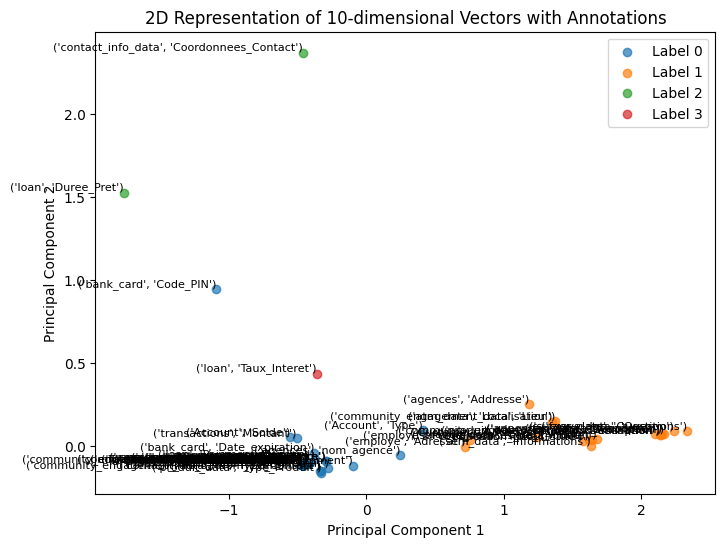

In [37]:
plot_2d_representation(data.iloc[:,:-1], data.iloc[:,-1], data.index)

In [38]:
data

0         1         2         3  \
Customer ID_Client            -0.166384  0.568400  0.221222 -0.350721   
         Nom                  -0.165158  0.564210  0.219591 -0.348136   
         Prenom               -0.164350  0.561451  0.218518 -0.346433   
         Genre                -0.166384  0.568400  0.221222 -0.350721   
         Date_de_Naissance    -0.166384  0.568400  0.221222 -0.350721   
...                                 ...       ...       ...       ...   
employe  NumeroSecuriteSocial -0.175576  0.566659  0.267359 -0.340841   
         Date_recrutement     -0.175576  0.566659  0.267359 -0.340841   
         Poste                -0.079579  0.148290 -0.000613  0.014069   
         Salaire              -0.175576  0.566659  0.267359 -0.340841   
         Departement          -0.114040  0.412800  0.223678 -0.261296   

                                      4         5         6         7  \
Customer ID_Client             0.061308  0.267381 -0.010562 -0.025128   
         Nom                   0.060856  0.265410 -0.010484 -0.024943   
         Prenom                0.060559  0.264112 -0.010433 -0.024821   
         Genre                 0.061308  0.267381 -0.010562 -0.025128   
         Date_de_Naissance     0.061308  0.267381 -0.010562 -0.025128   
...                                 ...       ...       ...       ...   
employe  NumeroSecuriteSocial  0.049297  0.253676 -0.025253 -0.017460   
         Date_recrutement      0.049297  0.253676 -0.025253 -0.017460   
         Poste                 0.083628  0.100373  0.135816  0.139432   
         Salaire               0.049297  0.253676 -0.025253 -0.017460   
         Departement          -0.047634  0.332980  0.156765  0.076638   

                                      8         9  ...        91        92  \
Customer ID_Client            -0.144777  0.092630  ... -0.275455  0.189930   
         Nom                  -0.143710  0.091948  ... -0.273425  0.188530   
         Prenom               -0.143007  0.091498  ... -0.272088  0.187608   
         Genre                -0.144777  0.092630  ... -0.275455  0.189930   
         Date_de_Naissance    -0.144777  0.092630  ... -0.275455  0.189930   
...                                 ...       ...  ...       ...       ...   
employe  NumeroSecuriteSocial -0.154363  0.069283  ... -0.235180  0.190544   
         Date_recrutement     -0.154363  0.069283  ... -0.235180  0.190544   
         Poste                 0.020148  0.062468  ... -0.268119  0.260442   
         Salaire              -0.154363  0.069283  ... -0.235180  0.190544   
         Departement          -0.031613  0.038170  ... -0.231696  0.290982   

                                     93        94        95        96  \
Customer ID_Client             0.204006 -0.567393  0.210087 -0.062517   
         Nom                   0.202503 -0.563211  0.208538 -0.062056   
         Prenom                0.201512 -0.560457  0.207518 -0.061753   
         Genre                 0.204006 -0.567393  0.210087 -0.062517   
         Date_de_Naissance     0.204006 -0.567393  0.210087 -0.062517   
...                                 ...       ...       ...       ...   
employe  NumeroSecuriteSocial  0.202815 -0.543838  0.191015 -0.049616   
         Date_recrutement      0.202815 -0.543838  0.191015 -0.049616   
         Poste                 0.414586 -0.207709  0.255631 -0.255602   
         Salaire               0.202815 -0.543838  0.191015 -0.049616   
         Departement           0.349977 -0.457443  0.304342 -0.005674   

                                     97        98        99  cluster  
Customer ID_Client            -0.389973  0.279994 -0.371168        0  
         Nom                  -0.387098  0.277931 -0.368432        0  
         Prenom               -0.385206  0.276571 -0.366630        0  
         Genre                -0.389973  0.279994 -0.371168        0  
         Date_de_Naissance    -0.389973  0.279994 -0.371168        0  
...                                 ...     

## Algorithmes de classification

In [124]:
from sklearn import tree
from sklearn import neighbors
from sklearn import linear_model
from sklearn import ensemble
from sklearn import svm
from sklearn import metrics
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

In [125]:
data = pd.read_csv("labeled_data.csv")

data.index = pd.MultiIndex.from_frame(data.loc[:,["Table", "Column"]])
data.drop(["Table", "Column"], axis=1, inplace=True)

In [129]:
data['sensitivity'] = data['sensitivity'].map(lambda x: 1 if x in ["Trés Secret", "Secret"] else 0)

In [130]:
X , y = data.iloc[:,:-1], data.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [161]:
l0 = ["DecisionTreeClassifier","LogisticRegression","RandomForestClassifier","SVC"]
l = []
#DecisionTreeClassifier
clf_tree = tree.DecisionTreeClassifier()
clf_tree.fit(X_train,y_train)
y_pred_tree = clf_tree.predict(X_test)
l.append(accuracy_score(y_test,y_pred_tree))
#KNeighborsClassifier
# clf_KNN = neighbors.KNeighborsClassifier()
# clf_KNN.fit(X_train,y_train)
# y_pred_KNN = clf_KNN.predict(X_test)
# l.append(accuracy_score(y_test,y_pred_KNN))
#LogisticRegression
clf_logRg = linear_model.LogisticRegression()
clf_logRg.fit(X_train,y_train)
y_pred_logRg = clf_logRg.predict(X_test)
l.append(accuracy_score(y_test,y_pred_logRg))
#RandomForestClassifier
clf_randFort = ensemble.RandomForestClassifier()
clf_randFort.fit(X_train,y_train)
y_pred_randFort = clf_randFort.predict(X_test)
l.append(accuracy_score(y_test,y_pred_randFort))
#SVC
clf_svc = svm.LinearSVC(max_iter=100000)
clf_svc.fit(X_train,y_train)
y_pred_svc = clf_svc.predict(X_test)
l.append(accuracy_score(y_test,y_pred_svc))

/home/ibra/ML-venv/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Text(0, 0.5, 'Accuracy')

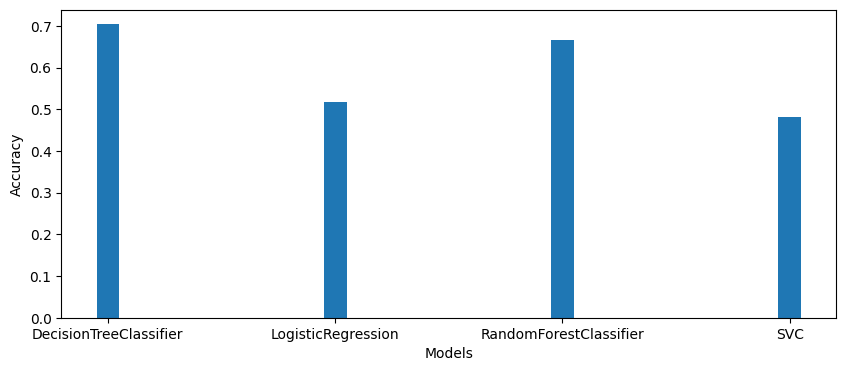

In [169]:
plt.figure(figsize=(10,4))
plt.bar(l0,l, width = 0.1)
plt.xlabel("Models")
plt.ylabel("Accuracy")

In [170]:
pd.DataFrame(metrics.classification_report(y_test,y_pred_tree,output_dict=True))

,0,1,accuracy,macro avg,weighted avg
precision,1.000000,0.384615,0.703704,0.692308,0.886040
recall,0.636364,1.000000,0.703704,0.818182,0.703704
f1-score,0.777778,0.555556,0.703704,0.666667,0.736626
support,22.000000,5.000000,0.703704,27.000000,27.000000


In [195]:
search = GridSearchCV(clf_tree,{'max_depth':[1,2,3,4,5,6,7,8,9,10]})
s = search.fit(X_train,y_train)
s.best_estimator_.fit(X_train,y_train)
y_pred_tree = s.best_estimator_.predict(X_test)
print(accuracy_score(y_test,y_pred_tree),s.best_params_)

0.7037037037037037 {'max_depth': 7}


In [183]:
pd.DataFrame(metrics.classification_report(y_test,y_pred_tree,output_dict=True))

,0,1,accuracy,macro avg,weighted avg
precision,1.000000,0.357143,0.666667,0.678571,0.880952
recall,0.590909,1.000000,0.666667,0.795455,0.666667
f1-score,0.742857,0.526316,0.666667,0.634586,0.702757
support,22.000000,5.000000,0.666667,27.000000,27.000000


## ELMO Embeddings

In [1]:
from simple_elmo import ElmoModel

2024-03-07 09:05:13.270339: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-07 09:05:13.756662: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-07 09:05:13.759864: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-07 09:05:16.183845: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
model = ElmoModel()

In [3]:
model.load("Elmo_embeddings")

2024-03-07 09:05:38,232 : INFO : Loading model from Elmo_embeddings...
2024-03-07 09:05:38,236 : INFO : No vocabulary file found in the model.
2024-03-07 09:05:38,237 : INFO : No model.hdf5 file found. Using Elmo_embeddings/elmo_original.hdf5 as a model file.
2024-03-07 09:05:38,239 : INFO : No vocabulary file provided; using special tokens only.
2024-03-07 09:05:38,240 : INFO : We will cache the vocabulary of 3 tokens.
/home/ibra/ML-venv/lib/python3.10/site-packages/simple_elmo/model.py:531: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  lstm_cell = tf.compat.v1.nn.rnn_cell.LSTMCell(


'The model is now loaded.'

In [4]:
sentences = [["I", "love", "NLP"]]
elmo_vectors = model.get_elmo_vector_average(sentences)

2024-03-07 09:05:44.718994: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:353] MLIR V1 optimization pass is not enabled
2024-03-07 09:05:49,885 : INFO : Warming up ELMo on 1 sentences...
2024-03-07 09:05:50,507 : INFO : Warming up finished.
2024-03-07 09:05:50,508 : INFO : Texts in the current batch: 1


In [5]:
def elmo_embeddings(column):
    return model.get_elmo_vector_average(column).reshape(1024)

In [11]:
data_elmo = []
columns = []
for tab_name in tables:
    tab = pd.read_csv(tab_name)
    for column in tab:
        columns.append((os.path.splitext(tab_name)[0], column))
        data_elmo.append(list(elmo_embeddings([column_to_string(tab.loc[:200,column]).split(" ")])))

2024-03-07 09:11:06,819 : INFO : Warming up ELMo on 1 sentences...
2024-03-07 09:11:16,666 : INFO : Warming up finished.
2024-03-07 09:11:16,672 : INFO : Texts in the current batch: 1
2024-03-07 09:11:29,638 : INFO : Warming up ELMo on 1 sentences...
2024-03-07 09:11:39,567 : INFO : Warming up finished.
2024-03-07 09:11:39,574 : INFO : Texts in the current batch: 1
2024-03-07 09:11:53,122 : INFO : Warming up ELMo on 1 sentences...
2024-03-07 09:12:06,403 : INFO : Warming up finished.
2024-03-07 09:12:06,421 : INFO : Texts in the current batch: 1
2024-03-07 09:12:22,723 : INFO : Warming up ELMo on 1 sentences...
2024-03-07 09:12:33,828 : INFO : Warming up finished.
2024-03-07 09:12:33,833 : INFO : Texts in the current batch: 1
2024-03-07 09:12:48,687 : INFO : Warming up ELMo on 1 sentences...
2024-03-07 09:12:58,809 : INFO : Warming up finished.
2024-03-07 09:12:58,817 : INFO : Texts in the current batch: 1
2024-03-07 09:13:11,653 : INFO : Warming up ELMo on 1 sentences...
2024-03-07 09

In [13]:
index = pd.MultiIndex.from_tuples(columns)

In [14]:
data_elmo = pd.DataFrame(data_elmo, index = index)

In [15]:
data_elmo

0         1         2         3     \
Customer ID_Client             0.009726  0.030831  0.028070  0.007475   
         Nom                  -0.019478 -0.030273 -0.003145 -0.021060   
         Prenom               -0.021030 -0.034288 -0.001263 -0.021735   
         Genre                 0.002776  0.007133 -0.025392  0.012451   
         Date_de_Naissance    -0.009334 -0.036058  0.023815 -0.009039   
...                                 ...       ...       ...       ...   
employe  NumeroSecuriteSocial  0.011429  0.030740 -0.011956 -0.046118   
         Date_recrutement      0.020155 -0.024905  0.011415 -0.034124   
         Poste                -0.043134  0.026580 -0.008482 -0.008029   
         Salaire               0.014558  0.000293  0.000138 -0.020842   
         Departement           0.012972 -0.002768 -0.000437 -0.038331   

                                   4         5         6         7     \
Customer ID_Client            -0.012459 -0.042745 -0.001438  0.045155   
         Nom                   0.013253 -0.039531 -0.000754  0.013008   
         Prenom                0.014513 -0.035216 -0.004901  0.004067   
         Genre                 0.044331 -0.010202 -0.022262  0.035630   
         Date_de_Naissance     0.034866 -0.016462  0.000235  0.023015   
...                                 ...       ...       ...       ...   
employe  NumeroSecuriteSocial -0.023463 -0.032847  0.017785  0.060844   
         Date_recrutement      0.002478 -0.027369 -0.004247  0.050631   
         Poste                 0.025632  0.055068 -0.038365  0.054879   
         Salaire              -0.003225 -0.028357  0.037215  0.042767   
         Departement          -0.001181  0.018225 -0.000765  0.071206   

                                   8         9     ...      1014      1015  \
Customer ID_Client             0.074347  0.018773  ... -0.060193  0.045592   
         Nom                   0.087411  0.035543  ... -0.082866  0.054331   
         Prenom                0.095868  0.037061  ... -0.071747  0.045153   
         Genre                 0.046234  0.025781  ... -0.072046  0.034475   
         Date_de_Naissance     0.068334  0.002826  ... -0.015107  0.040777   
...                                 ...       ...  ...       ...       ...   
employe  NumeroSecuriteSocial  0.082534  0.001058  ... -0.012168  0.036697   
         Date_recrutement      0.076065  0.024641  ... -0.018327  0.016140   
         Poste                 0.022317  0.006937  ... -0.011275  0.049540   
         Salaire               0.092398  0.018618  ... -0.012249  0.049678   
         Departement           0.077469 -0.030797  ... -0.001231  0.034807   

                                   1016      1017      1018      1019  \
Customer ID_Client            -0.013885  0.008293  0.040226 -0.014760   
         Nom                  -0.029507 -0.006593  0.022733  0.024150   
         Prenom               -0.035569  0.000090  0.014280  0.020772   
         Genre                -0.016774  0.045966  0.071150 -0.036361   
         Date_de_Naissance     0.035451  0.024845  0.034532  0.037234   
...                                 ...       ...       ...       ...   
employe  NumeroSecuriteSocial  0.028076 -0.000232  0.010809 -0.004166   
         Date_recrutement      0.047417  0.003231  0.030950  0.011799   
         Poste                 0.000184  0.027017  0.036131 -0.026182   
         Salaire               0.036381  0.025603  0.022700  0.006263   
         Departement          -0.002748 -0.002347  0.024368 -0.005714   

                                   1020      1021      1022      1023  
Customer ID_Client             0.027324  0.021048 -0.026245  0.053410  
         Nom                   0.029698  0.006363  0.034189  0.035481  
         Prenom                0.030076  0.006992  0.040327  0.039525  
         Genre                 0.049902  0.007284  0.017209  0.027655  
         Date_de_Naissance    -0.030832  0.009097  0.002400  0.044752  
...                                

In [16]:
data_elmo.to_csv("elmo_embeddings.csv")

In [21]:
clustering_for_initial_labeling(data_elmo)

0         1         2         3  \
Customer ID_Client             0.009726  0.030831  0.028070  0.007475   
         Nom                  -0.019478 -0.030273 -0.003145 -0.021060   
         Prenom               -0.021030 -0.034288 -0.001263 -0.021735   
         Genre                 0.002776  0.007133 -0.025392  0.012451   
         Date_de_Naissance    -0.009334 -0.036058  0.023815 -0.009039   
...                                 ...       ...       ...       ...   
employe  NumeroSecuriteSocial  0.011429  0.030740 -0.011956 -0.046118   
         Date_recrutement      0.020155 -0.024905  0.011415 -0.034124   
         Poste                -0.043134  0.026580 -0.008482 -0.008029   
         Salaire               0.014558  0.000293  0.000138 -0.020842   
         Departement           0.012972 -0.002768 -0.000437 -0.038331   

                                      4         5         6         7  \
Customer ID_Client            -0.012459 -0.042745 -0.001438  0.045155   
         Nom                   0.013253 -0.039531 -0.000754  0.013008   
         Prenom                0.014513 -0.035216 -0.004901  0.004067   
         Genre                 0.044331 -0.010202 -0.022262  0.035630   
         Date_de_Naissance     0.034866 -0.016462  0.000235  0.023015   
...                                 ...       ...       ...       ...   
employe  NumeroSecuriteSocial -0.023463 -0.032847  0.017785  0.060844   
         Date_recrutement      0.002478 -0.027369 -0.004247  0.050631   
         Poste                 0.025632  0.055068 -0.038365  0.054879   
         Salaire              -0.003225 -0.028357  0.037215  0.042767   
         Departement          -0.001181  0.018225 -0.000765  0.071206   

                                      8         9  ...      1015      1016  \
Customer ID_Client             0.074347  0.018773  ...  0.045592 -0.013885   
         Nom                   0.087411  0.035543  ...  0.054331 -0.029507   
         Prenom                0.095868  0.037061  ...  0.045153 -0.035569   
         Genre                 0.046234  0.025781  ...  0.034475 -0.016774   
         Date_de_Naissance     0.068334  0.002826  ...  0.040777  0.035451   
...                                 ...       ...  ...       ...       ...   
employe  NumeroSecuriteSocial  0.082534  0.001058  ...  0.036697  0.028076   
         Date_recrutement      0.076065  0.024641  ...  0.016140  0.047417   
         Poste                 0.022317  0.006937  ...  0.049540  0.000184   
         Salaire               0.092398  0.018618  ...  0.049678  0.036381   
         Departement           0.077469 -0.030797  ...  0.034807 -0.002748   

                                   1017      1018      1019      1020  \
Customer ID_Client             0.008293  0.040226 -0.014760  0.027324   
         Nom                  -0.006593  0.022733  0.024150  0.029698   
         Prenom                0.000090  0.014280  0.020772  0.030076   
         Genre                 0.045966  0.071150 -0.036361  0.049902   
         Date_de_Naissance     0.024845  0.034532  0.037234 -0.030832   
...                                 ...       ...       ...       ...   
employe  NumeroSecuriteSocial -0.000232  0.010809 -0.004166  0.026820   
         Date_recrutement      0.003231  0.030950  0.011799  0.004663   
         Poste                 0.027017  0.036131 -0.026182  0.023242   
         Salaire               0.025603  0.022700  0.006263  0.023386   
         Departement          -0.002347  0.024368 -0.005714  0.029277   

                                   1021      1022      1023  cluster  
Customer ID_Client             0.021048 -0.026245  0.053410        0  
         Nom                   0.006363  0.034189  0.035481        2  
         Prenom                0.006992  0.040327  0.039525        2  
         Genre                 0.007284  0.017209  0.027655        2  
         Date_de_Naissance     0.009097  0.002400  0.044752        3  
...                                 ...     

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA


# Function to plot 2D representation of 10-dimensional vectors
def plot_2d_representation(data, labels, names):
    pca = PCA(n_components=2)
    reduced_data = pca.fit_transform(data)

    plt.figure(figsize=(8, 6))
    for label in np.unique(labels):
        indices = labels == label
        plt.scatter(reduced_data[indices, 0], reduced_data[indices, 1], label=f'Label {label}', alpha=0.7)
        for i, name in enumerate(names):
            if indices[i]:
                plt.text(reduced_data[i, 0], reduced_data[i, 1], f"{name[0]}_{name[1]}", fontsize=8, ha='right', va='bottom')

    plt.title('2D Representation of 10-dimensional Vectors with Annotations')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend()
    plt.show()

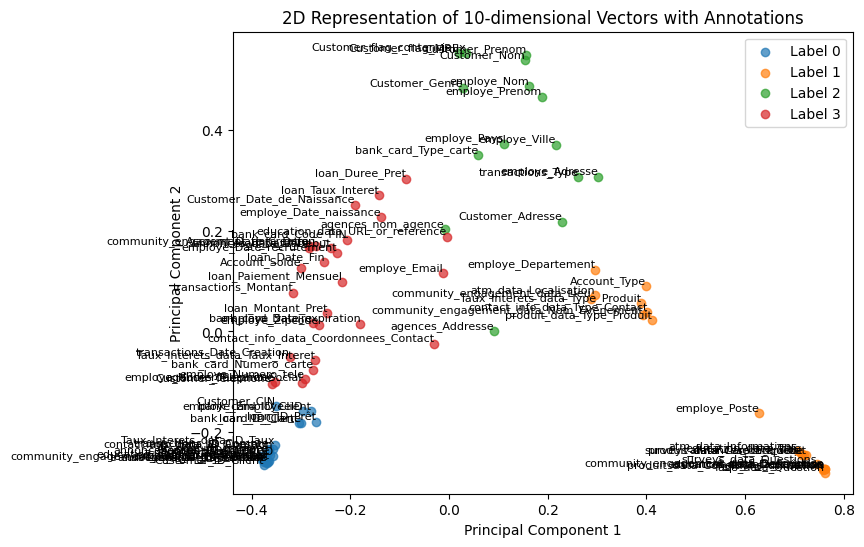

In [28]:
plot_2d_representation(data_elmo.iloc[:,:-1], data_elmo.iloc[:,-1], data_elmo.index)

In [42]:
data_elmo[data_elmo.loc[:,"cluster"]==2].index

MultiIndex([(    'Customer',              'Nom'),
            (    'Customer',           'Prenom'),
            (    'Customer',            'Genre'),
            (    'Customer',          'Adresse'),
            (    'Customer',         'flag_MRE'),
            (    'Customer', 'flag_contencieux'),
            (     'agences',       'nom_agence'),
            (     'agences',         'Addresse'),
            (   'bank_card',       'Type_carte'),
            ('transactions',             'Type'),
            (     'employe',              'Nom'),
            (     'employe',           'Prenom'),
            (     'employe',          'Adresse'),
            (     'employe',            'Ville'),
            (     'employe',             'Pays')],
           )